# Snowflake for [DataMesh](https://www.snowflake.com/en/use-cases/data-mesh/)

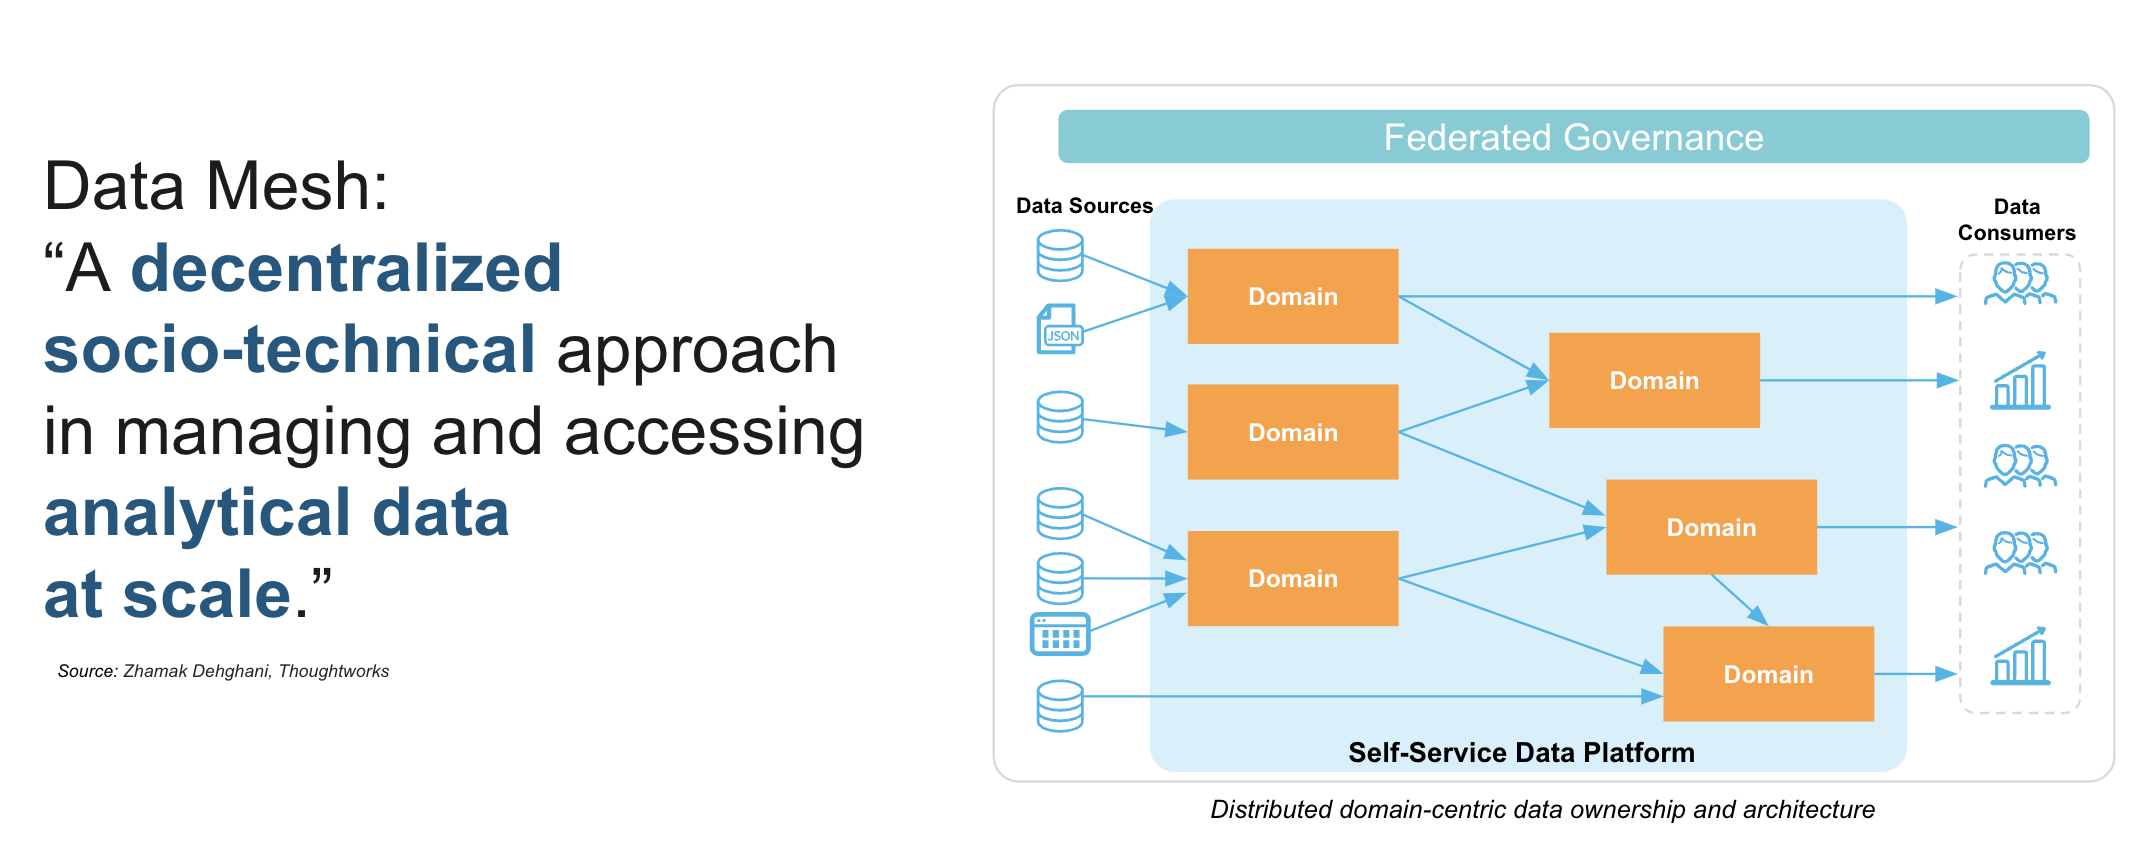

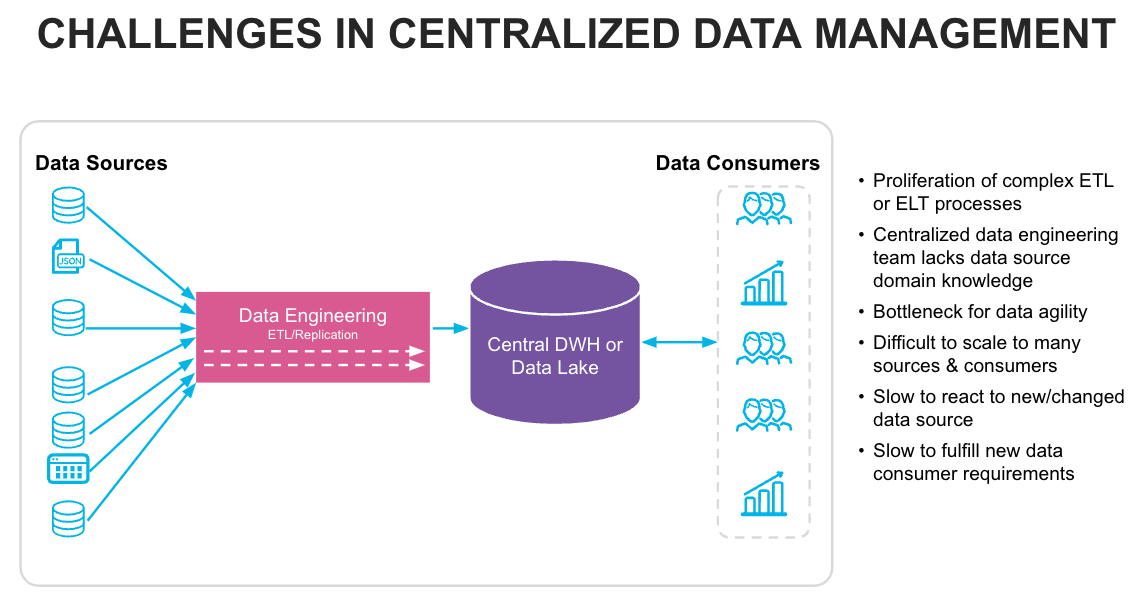

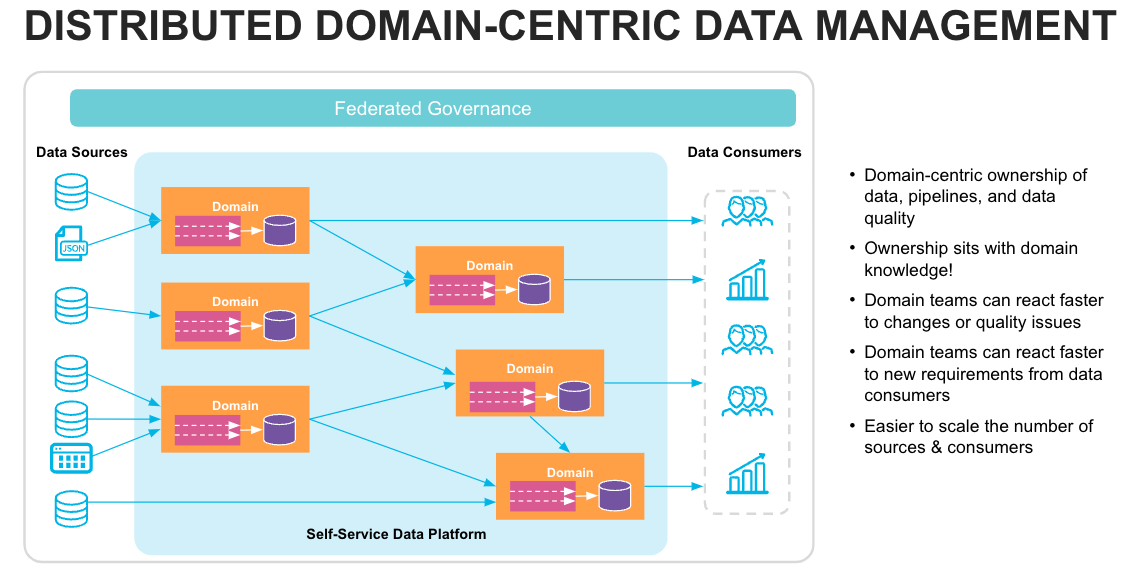

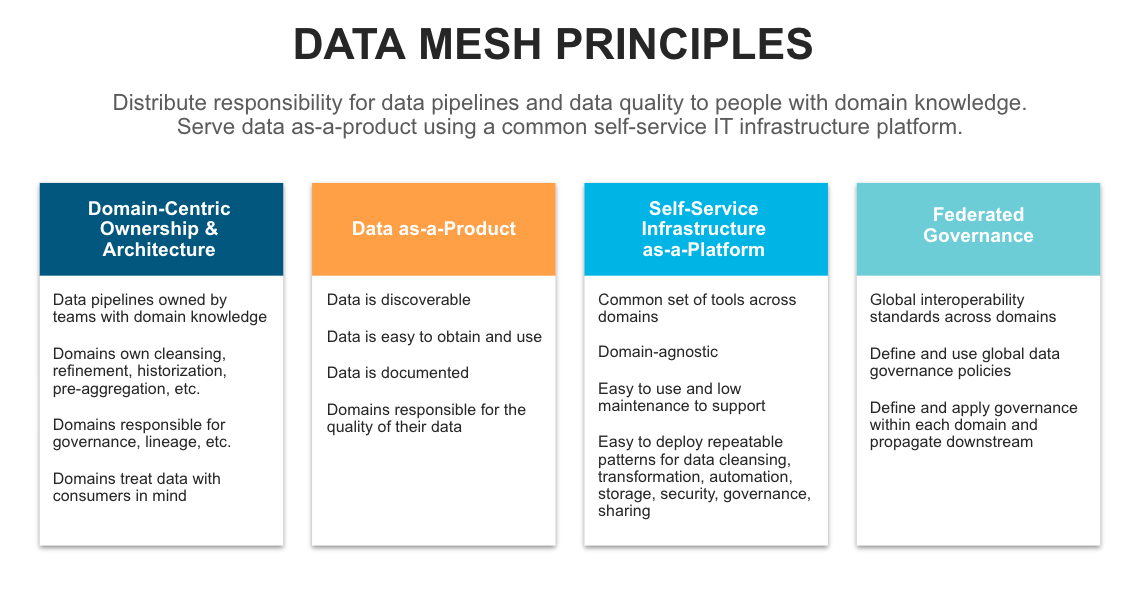

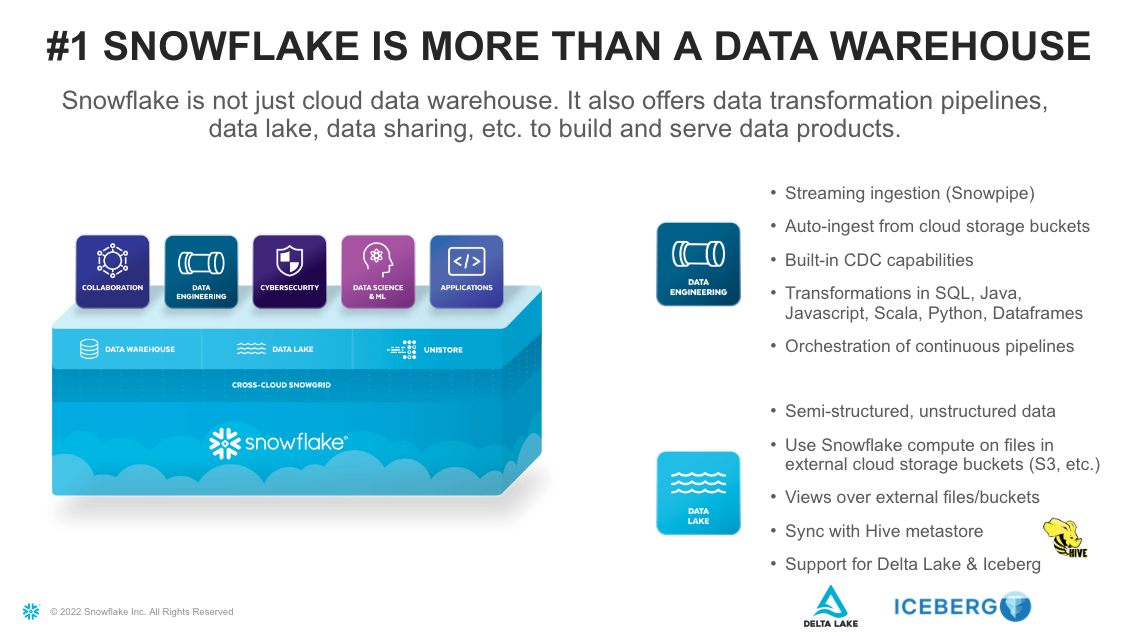

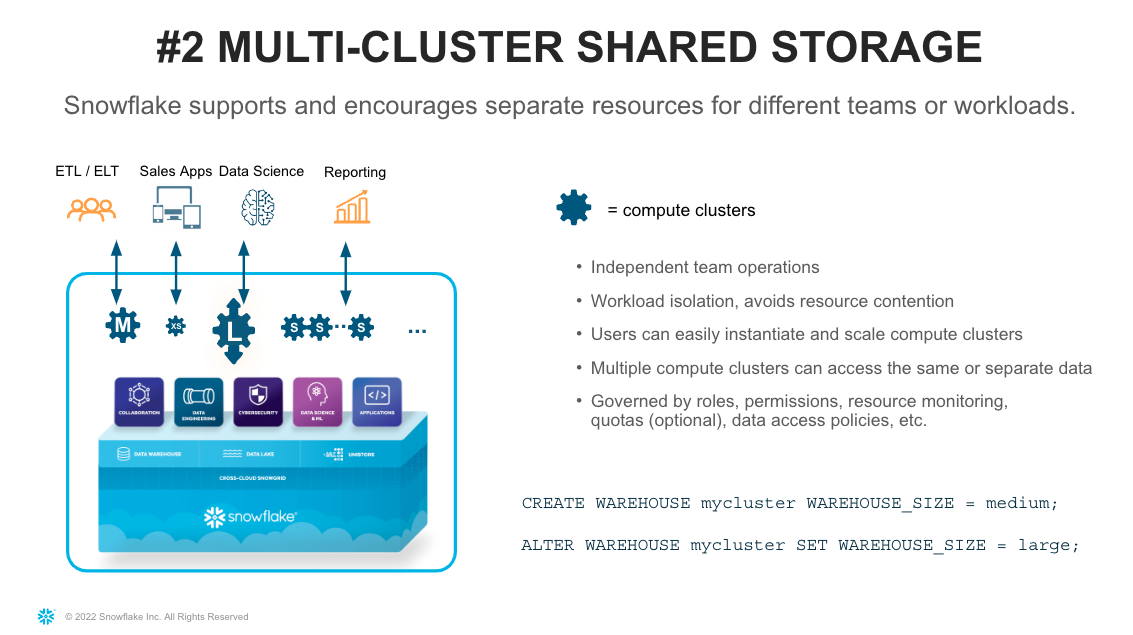

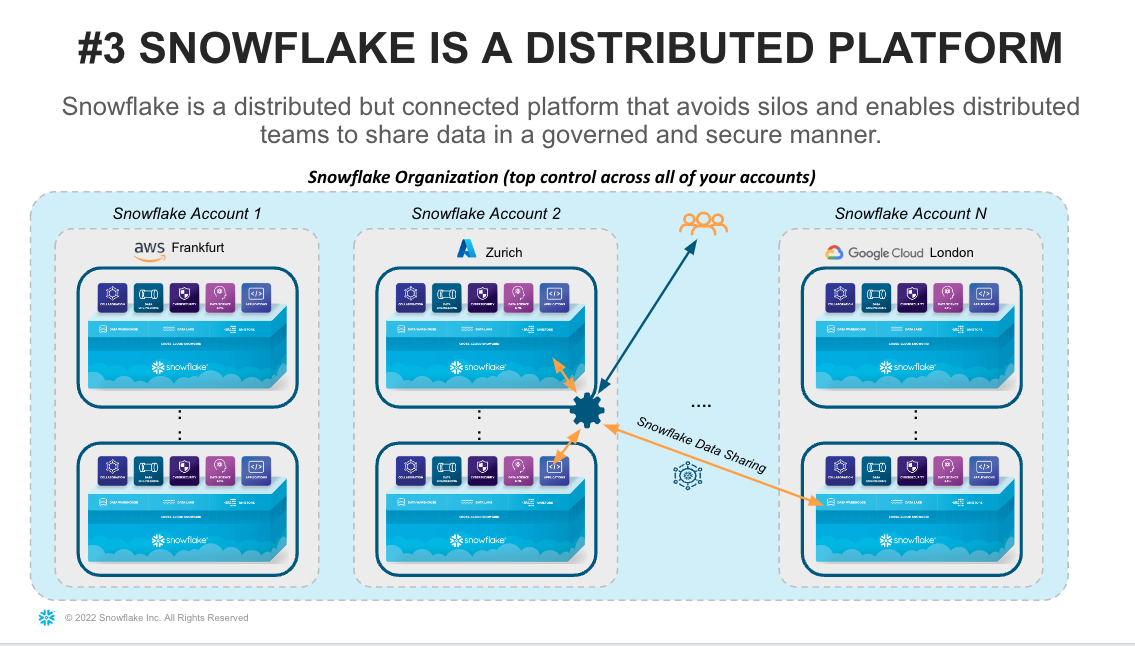

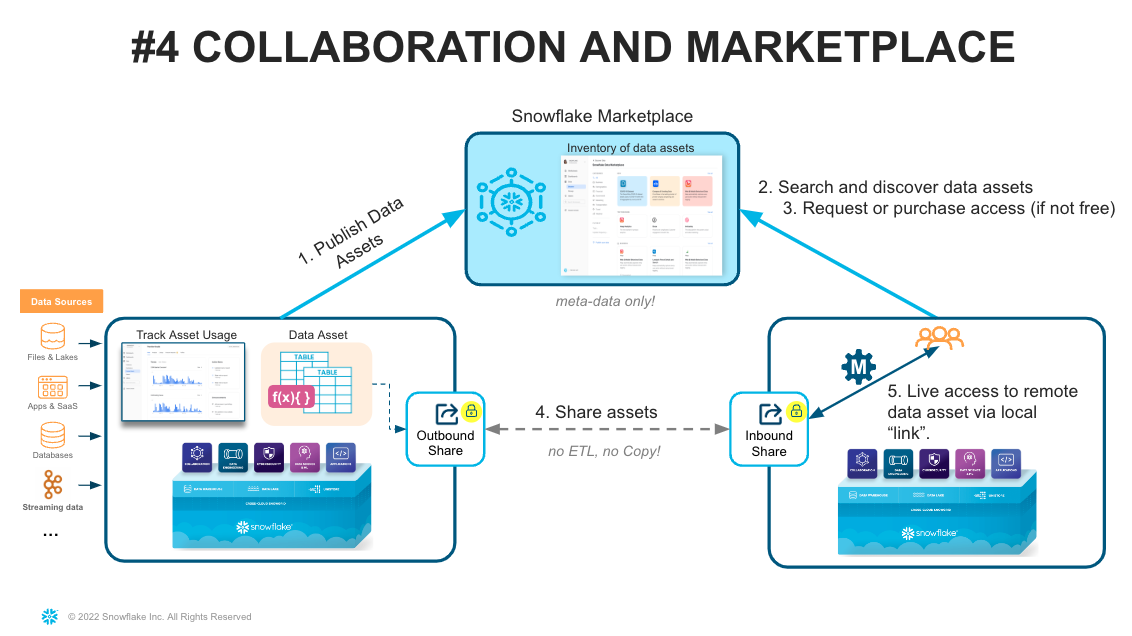

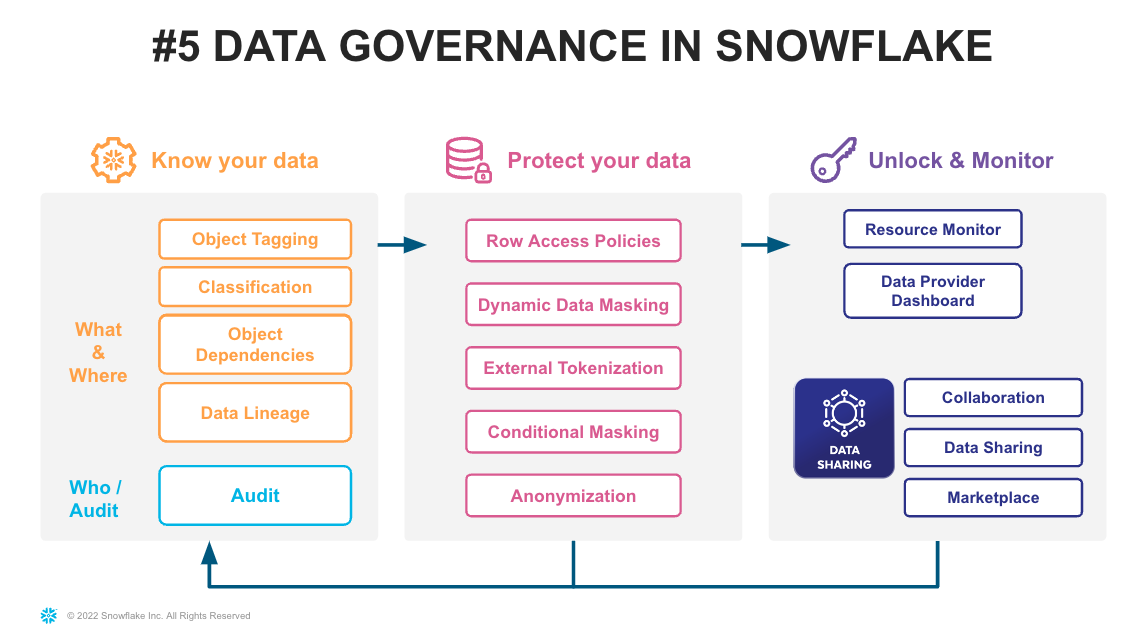

# DATA MESH - Scenario we are going to cover
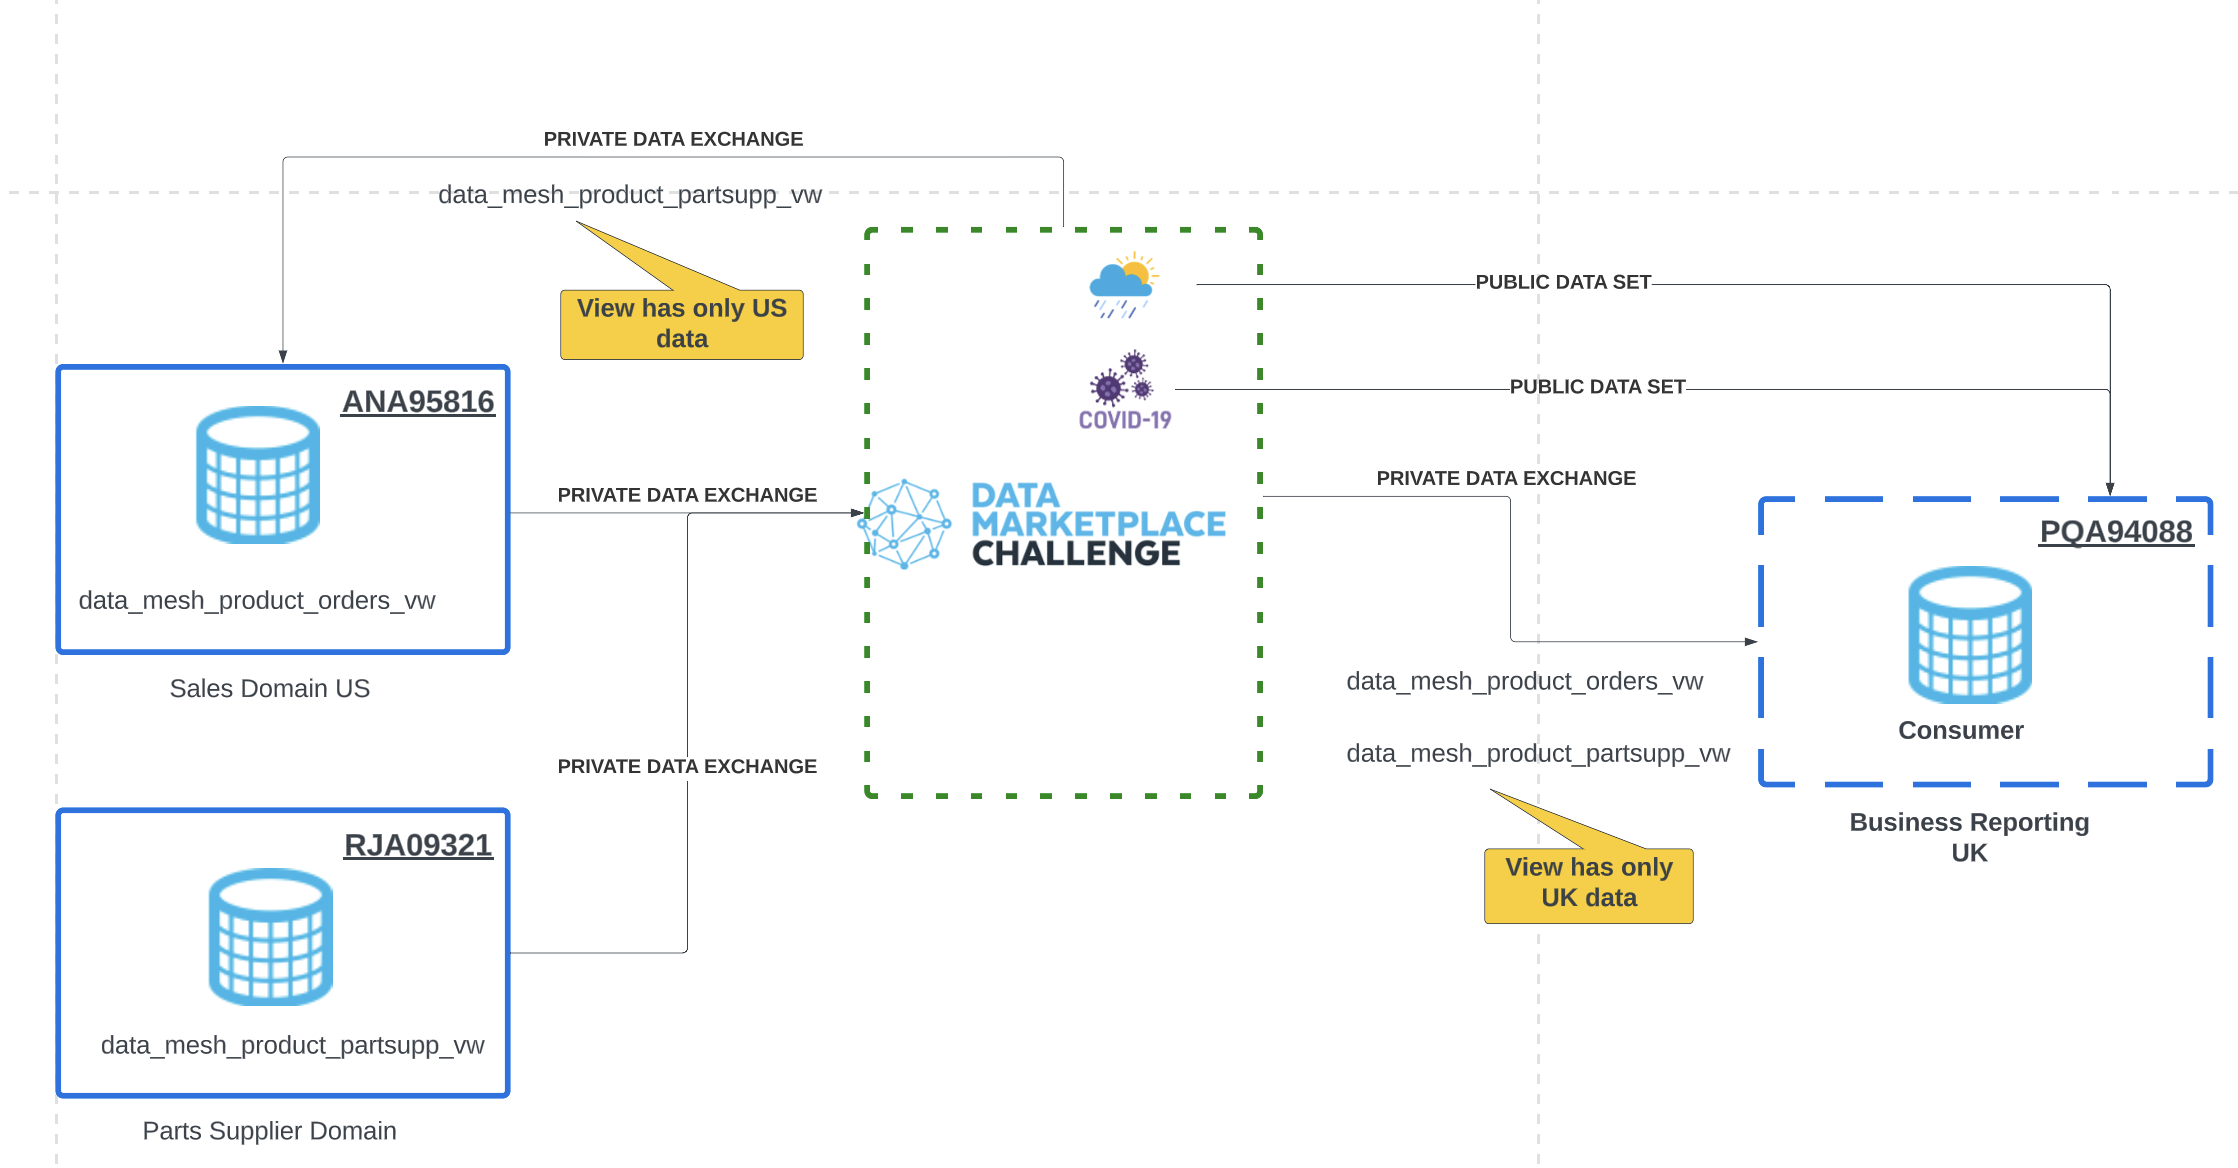

## <ins>Data Product 1 - Orders data from Sales team</ins>

### CREATING DATAPRODUCT - data_mesh_product_orders_vw (view in Snowflake account VT70696)

In [8]:
# Establishing session in Snowflake
import snowflake.snowpark
from snowflake.snowpark.functions import sproc
from snowflake.snowpark.session import Session
from snowflake.snowpark import version as v
import json
from config import snowflake_conn_prop_local as snowflake_udf_conn_prop

import pandas as pd
import numpy as np
import datetime
import io

session = Session.builder.configs(snowflake_udf_conn_prop).create()
print(session.sql('select current_account(), current_warehouse(), current_database(), current_schema()').collect())

session.add_packages('snowflake-snowpark-python', 'pandas', 'numpy')

[Row(CURRENT_ACCOUNT()='ANA95816', CURRENT_WAREHOUSE()='DEMO_QAS_WH', CURRENT_DATABASE()='BRONZE_LAYER', CURRENT_SCHEMA()='PUBLIC')]


In [2]:
session.sql("select current_account()").collect()

[Row(CURRENT_ACCOUNT()='ANA95816')]

### View creation from the dataset that was loaded in DataLake demo

In [3]:
%%time
session.sql("create or replace secure view data_mesh_product_orders_vw as (  \
SELECT C_NAME, O_ORDERDATE, SUM(O_TOTALPRICE) as overall_price  FROM ORDERS O   \
JOIN CUSTOMER C ON O.O_CUSTKEY = C.C_CUSTKEY  \
JOIN LINEITEM L ON L.L_ORDERKEY = O.O_ORDERKEY  \
group by C_NAME, O_ORDERDATE order by overall_price); \
            ").collect()

CPU times: user 3.85 ms, sys: 1.9 ms, total: 5.75 ms
Wall time: 384 ms


[Row(status='View DATA_MESH_PRODUCT_ORDERS_VW successfully created.')]

### Sharing the view with Consumer account PQA94088 --> DIRECT SHARE

In [4]:
## Data sharing
session.sql("CREATE OR REPLACE SHARE ORDERS_SHARE;").collect()
session.sql("grant usage on database BRONZE_LAYER to SHARE ORDERS_SHARE;;").collect()
session.sql("grant usage on schema BRONZE_LAYER.PUBLIC to SHARE ORDERS_SHARE;").collect()
session.sql("grant select on view  BRONZE_LAYER.PUBLIC.DATA_MESH_PRODUCT_ORDERS_VW to SHARE ORDERS_SHARE;").collect()
session.sql("ALTER SHARE ORDERS_SHARE ADD ACCOUNTS = PQA94088;").collect() #-- Update the account identifier



[Row(status='Statement executed successfully.')]

# How to create a Private Listing

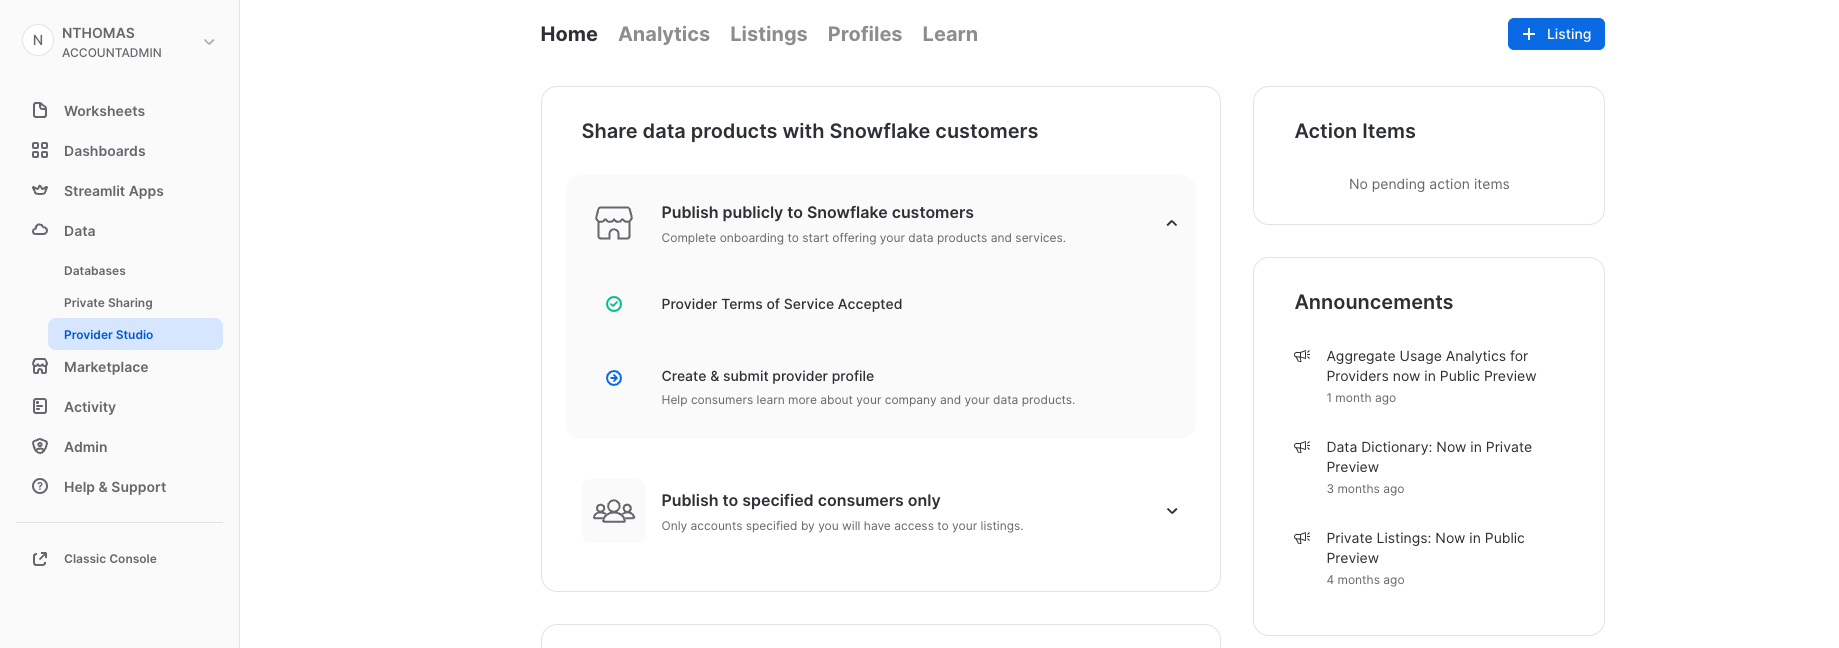

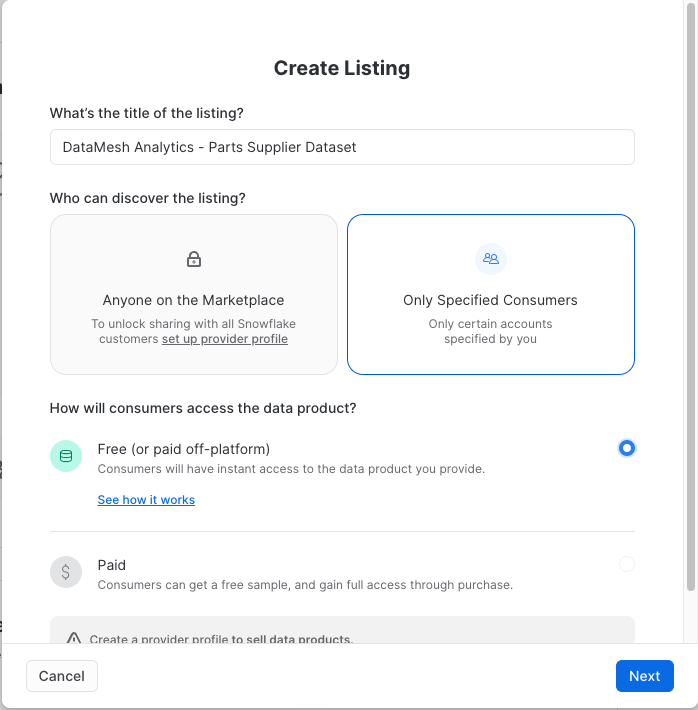

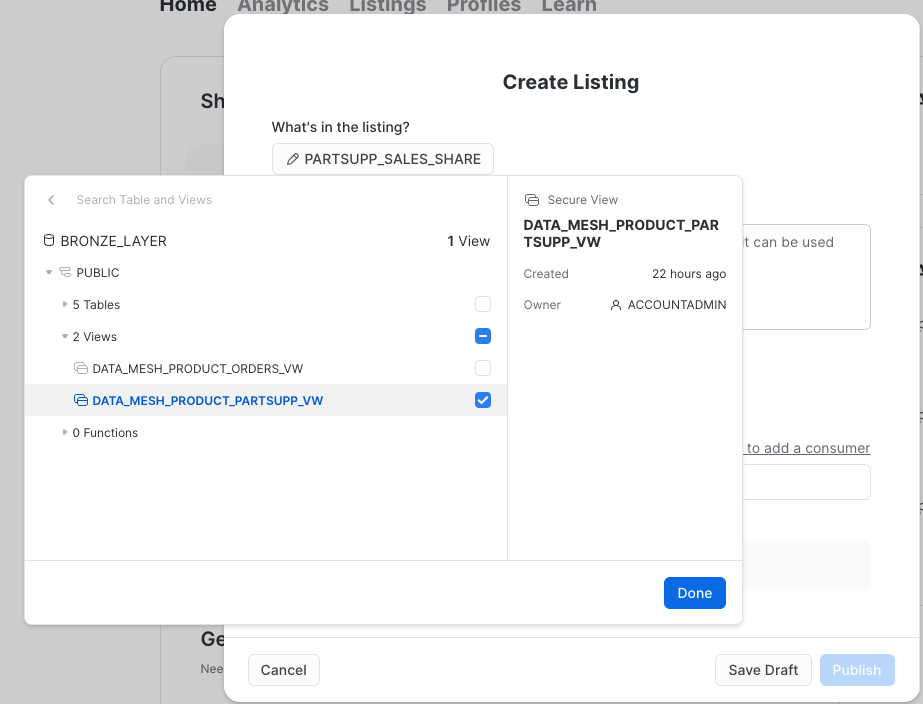

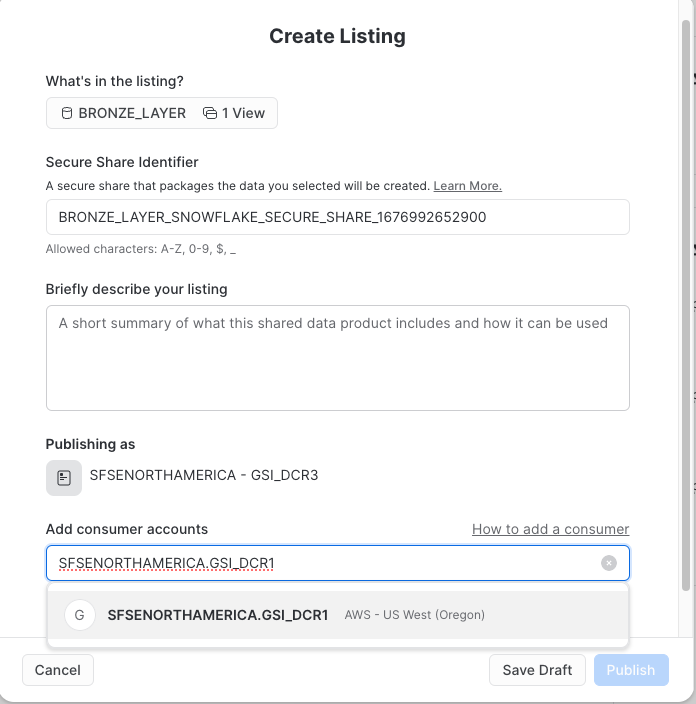

# How to consume a private listing

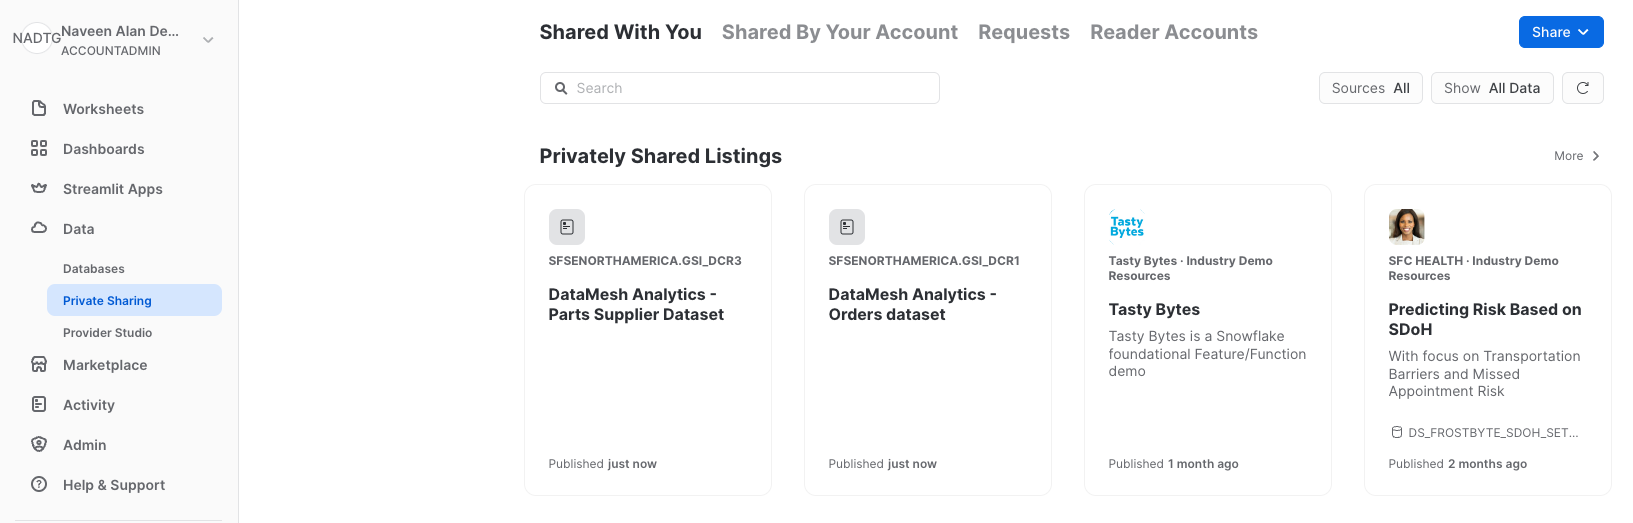

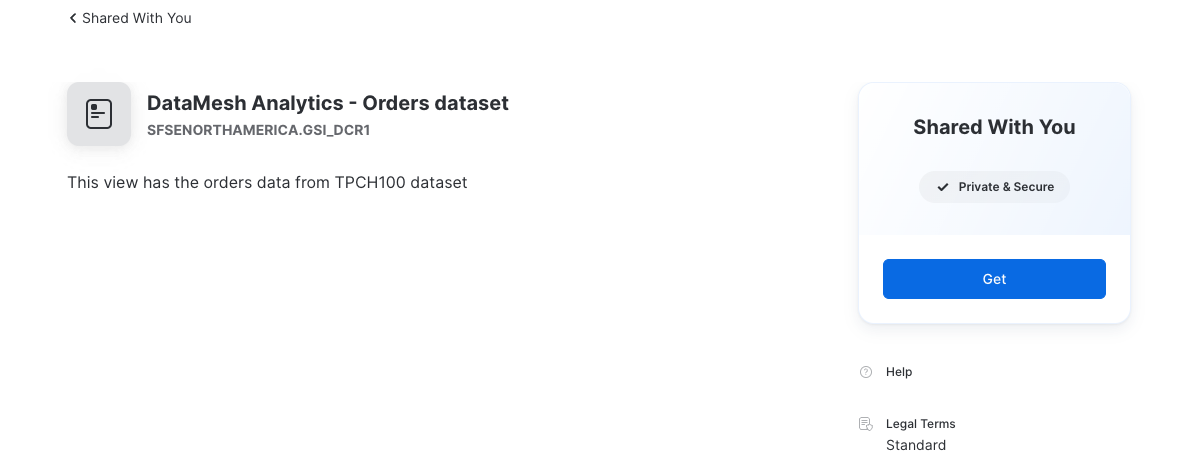

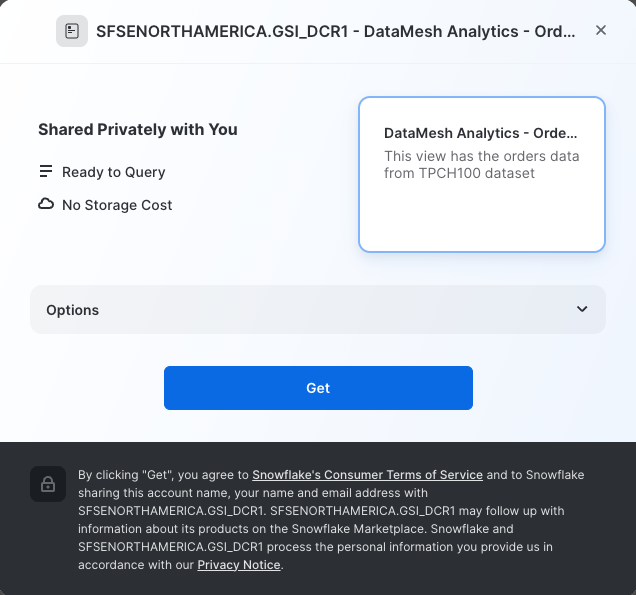

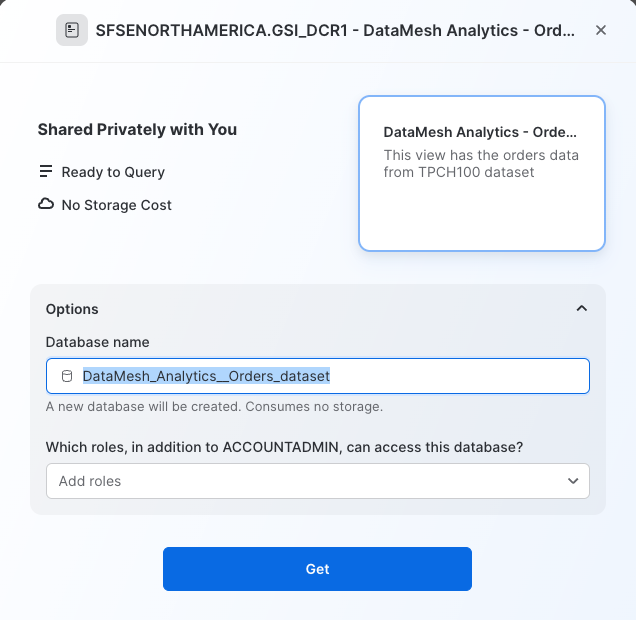

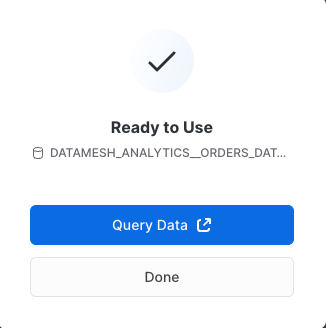

# SALES US Domain consuming data from Procurement Domain

In [10]:
session.sql("SHOW SHARES like '%PARTSUPP_SALES_SHARE%';").collect()

[Row(created_on=datetime.datetime(2023, 2, 20, 8, 35, 40, 238000, tzinfo=<DstTzInfo 'America/Los_Angeles' PST-1 day, 16:00:00 STD>), kind='INBOUND', name='SFSENORTHAMERICA.GSI_DCR3.PARTSUPP_SALES_SHARE', database_name='', to='', owner='', comment='', listing_global_name='')]

In [11]:
session.sql("CREATE OR REPLACE DATABASE BI_LAYER_PARTSUPP_DB FROM SHARE SFSENORTHAMERICA.GSI_DCR3.PARTSUPP_SALES_SHARE;").collect()

[Row(status='Database BI_LAYER_PARTSUPP_DB successfully created.')]

In [12]:
%%time
session.sql("SELECT * FROM BI_LAYER_PARTSUPP_DB.PUBLIC.DATA_MESH_PRODUCT_PARTSUPP_VW limit 5").to_pandas()

CPU times: user 10.7 ms, sys: 7.22 ms, total: 17.9 ms
Wall time: 5.58 s


,PS_PARTKEY,P_NAME,N_NAME,AVAILABLE_QUANTITY,TOTAL_COST_ACROSS_SUPPLIERS
0,5670520,blanched khaki chocolate azure forest,UNITED STATES,6493,438.56
1,8767818,violet royal goldenrod white magenta,UNITED STATES,6493,442.23
2,11701766,sky mint almond goldenrod slate,UNITED STATES,6493,443.31
3,4387100,drab deep green linen slate,UNITED STATES,6493,443.60
4,6158443,steel chocolate blush salmon goldenrod,UNITED STATES,6493,453.87


In [13]:
if session:
    session.close()